<a href="https://colab.research.google.com/github/NgPcAnhh/Data/blob/master/training_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bước 1: Import thư viện

In [ ]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

Bước 2: Đọc dữ liệu

In [ ]:

# đọc dữ liệu từ file csv
df = pd.read_csv('FPT (1).csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["Ticker"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

              Date/Time   Open   High    Low  Close  Volume
0       12/25/2018 9:15  30.89  30.89  30.89  30.89   35410
1       12/25/2018 9:16  30.81  30.81  30.81  30.81     190
2       12/25/2018 9:17  30.74  30.81  30.74  30.74    1120
3       12/25/2018 9:18  30.74  30.74  30.74  30.74    2120
4       12/25/2018 9:19  30.74  30.74  30.74  30.74   22500
...                 ...    ...    ...    ...    ...     ...
97401  12/22/2020 14:24  58.20  58.20  58.20  58.20   27470
97402  12/22/2020 14:25  58.20  58.20  58.20  58.20   14820
97403  12/22/2020 14:26  58.20  58.20  58.20  58.20     500
97404  12/22/2020 14:29  58.10  58.10  58.10  58.10    2500
97405  12/22/2020 14:46  58.10  58.10  58.10  58.10   11170

[97406 rows x 6 columns]


In [ ]:
print(df.columns)


Index(['Date/Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


Mô tả dữ liệu

In [ ]:
#định dạng cấu trúc thời gian
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')
df.index = df['Date/Time']

In [ ]:
#kích thước dữ liệu
df.shape

(97406, 6)

In [ ]:
#dữ liệu 5 dòng đầu
df.head()

,Date/Time,Open,High,Low,Close,Volume
Date/Time,,,,,,
2018-12-25 09:15:00,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
2018-12-25 09:16:00,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2018-12-25 09:17:00,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
2018-12-25 09:18:00,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
2018-12-25 09:19:00,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


In [ ]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97406 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date/Time  97406 non-null  datetime64[ns]
 1   Open       97406 non-null  float64       
 2   High       97406 non-null  float64       
 3   Low        97406 non-null  float64       
 4   Close      97406 non-null  float64       
 5   Volume     97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 5.2 MB


In [ ]:
#mô tả bộ dữ liệu
df.describe()

,Date/Time,Open,High,Low,Close,Volume
count,97406,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04
mean,2020-01-21 05:08:51.739112192,45.071630,45.090138,45.051430,45.071631,8.044173e+03
min,2018-12-25 09:15:00,30.250000,30.250000,30.220000,30.250000,1.000000e+01
25%,2019-08-06 11:06:15,39.740000,39.740000,39.700000,39.740000,7.500000e+02
50%,2020-01-31 10:37:30,46.950000,46.950000,46.950000,46.950000,2.960000e+03
75%,2020-07-14 09:54:45,49.200000,49.250000,49.170000,49.200000,8.960000e+03
max,2020-12-22 14:46:00,58.400000,58.500000,58.400000,58.400000,1.255930e+06
std,NaN,6.359803,6.364950,6.354245,6.359799,1.753203e+04


Bước 4: Tiền xử lý dữ liệu và xây dựng, huấn luyện mô hình

In [ ]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


<ipython-input-10-e37cef57fffd>:31: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ohlc['Date_num'] = mdates.date2num(ohlc['Date/Time'].dt.to_pydatetime())


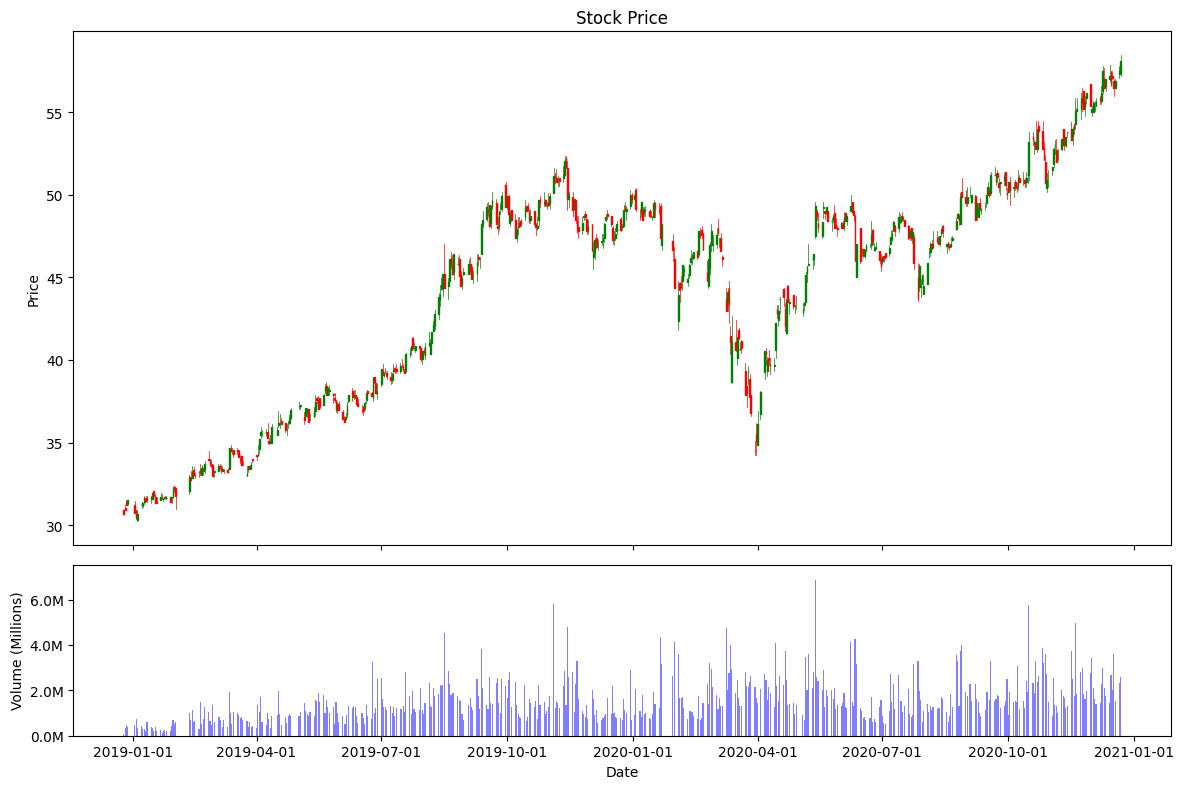

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Check if 'Date/Time' is already the index
if 'Date/Time' not in df.columns:
    # If 'Date/Time' is the index, reset it to be a column
    df = df.reset_index()

# Convert Date/Time column to datetime if it's not already
if df['Date/Time'].dtype != 'datetime64[ns]':
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Set Date/Time as index
df.set_index('Date/Time', inplace=True)

# Create a new DataFrame with OHLC data
ohlc = df[['Open', 'High', 'Low', 'Close']].resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()  # Drop rows with NaN values

# Reset index to get Date as a column for plotting
ohlc.reset_index(inplace=True)

# Convert Date to number for plotting
ohlc['Date_num'] = mdates.date2num(ohlc['Date/Time'].dt.to_pydatetime())

# Create the main figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot candlestick chart
candlestick_ohlc(ax1, ohlc[['Date_num', 'Open', 'High', 'Low', 'Close']].values, width=0.6, colorup='g', colordown='r')

# Set x-axis format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Set labels and title for candlestick chart
ax1.set_ylabel('Price')
ax1.set_title('Stock Price')

# Plot volume bar chart
volume = df['Volume'].resample('D').sum()
ax2.bar(volume.index, volume.values, color='b', alpha=0.5)

# Set y-axis limits for volume chart
max_volume = volume.max()
ax2.set_ylim(0, max_volume * 1.1)  # Increase upper limit by 10%

# Format y-axis labels to millions
def millions(x, pos):
    return f'{x/1e6:.1f}M'

ax2.yaxis.set_major_formatter(FuncFormatter(millions))

# Set labels for volume chart
ax2.set_ylabel('Volume (Millions)')
ax2.set_xlabel('Date')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Lấy cột 'Date/Time' và 'Close' từ DataFrame gốc
df1 = df[['Date/Time', 'Close']].copy()

# Đặt 'Date/Time' làm index
df1.set_index('Date/Time', inplace=True)

# Hiển thị DataFrame kết quả
df1

,Close
Date/Time,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74
...,...
2020-12-22 14:24:00,58.20
2020-12-22 14:25:00,58.20
2020-12-22 14:26:00,58.20


In [ ]:
#chia tập dữ liệu
data = df1.values
train_data = data[:80000]
test_data = data[80000:]

In [ ]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

Khởi tạo các ma trận

In [ ]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [ ]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

Bước 5: Xây dựng và huấn luyện mô hình

In [ ]:
#xây dựng mô hình
model = Sequential() # tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cập nhật đường dẫn tệp lưu mô hình với phần mở rộng .keras
save_model = "/content/drive/MyDrive/dataset/save_model.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/100

Epoch 1: loss improved from inf to 0.02044, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 179s - 112ms/step - loss: 0.0204
Epoch 2/100

Epoch 2: loss improved from 0.02044 to 0.01868, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 198s - 124ms/step - loss: 0.0187
Epoch 3/100

Epoch 3: loss improved from 0.01868 to 0.01852, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 204s - 127ms/step - loss: 0.0185
Epoch 4/100

Epoch 4: loss improved from 0.01852 to 0.01825, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 203s - 127ms/step - loss: 0.0183
Epoch 5/100

Epoch 5: loss improved from 0.01825 to 0.01803, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 199s - 124ms/step - loss: 0.0180
Epoch 6/100

Epoch 6: loss improved from 0.01803 to 0.01797, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 177s - 111ms/step

In [ ]:
# dữ liệu dài, chia 2 ngày nên phải có phần code để lưu lại checkpoint
from tensorflow.keras.models import load_model

# Đường dẫn đến mô hình đã lưu
save_model = "/content/drive/MyDrive/dataset/save_model.keras"

# Tải lại mô hình từ checkpoint đã lưu
model = load_model(save_model)
print("Model loaded from Google Drive")

Model loaded from Google Drive


In [ ]:
# load tiếp checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

# Đường dẫn để lưu mô hình
save_model = "/content/drive/MyDrive/dataset/save_model.keras"

# Định nghĩa lại checkpoint callback để tiếp tục lưu mô hình tốt nhất
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Tiếp tục huấn luyện mô hình từ epoch 76 đến 100
model.fit(x_train, y_train, initial_epoch=74, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 75/100

Epoch 75: loss improved from inf to 0.01720, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 220s - 138ms/step - loss: 0.0172
Epoch 76/100

Epoch 76: loss improved from 0.01720 to 0.01719, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 211s - 132ms/step - loss: 0.0172
Epoch 77/100

Epoch 77: loss improved from 0.01719 to 0.01714, saving model to /content/drive/MyDrive/dataset/save_model.keras
1599/1599 - 264s - 165ms/step - loss: 0.0171
Epoch 78/100

Epoch 78: loss did not improve from 0.01714
1599/1599 - 272s - 170ms/step - loss: 0.0172
Epoch 79/100

Epoch 79: loss did not improve from 0.01714
1599/1599 - 211s - 132ms/step - loss: 0.0173
Epoch 80/100

Epoch 80: loss did not improve from 0.01714
1599/1599 - 211s - 132ms/step - loss: 0.0173
Epoch 81/100

Epoch 81: loss did not improve from 0.01714
1599/1599 - 263s - 165ms/step - loss: 0.0172
Epoch 82/100

Epoch 82: loss did not improve from 0.01714
1599/1599 - 268s -

In [ ]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/dataset/save_model.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

2499/2499 ━━━━━━━━━━━━━━━━━━━━ 101s 40ms/step


Bước 6: Tái sử dụng mô hình

In [ ]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[80000:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step


Độ chính xác của mô hình

<ipython-input-29-e26c0c6bb522>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-29-e26c0c6bb522>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


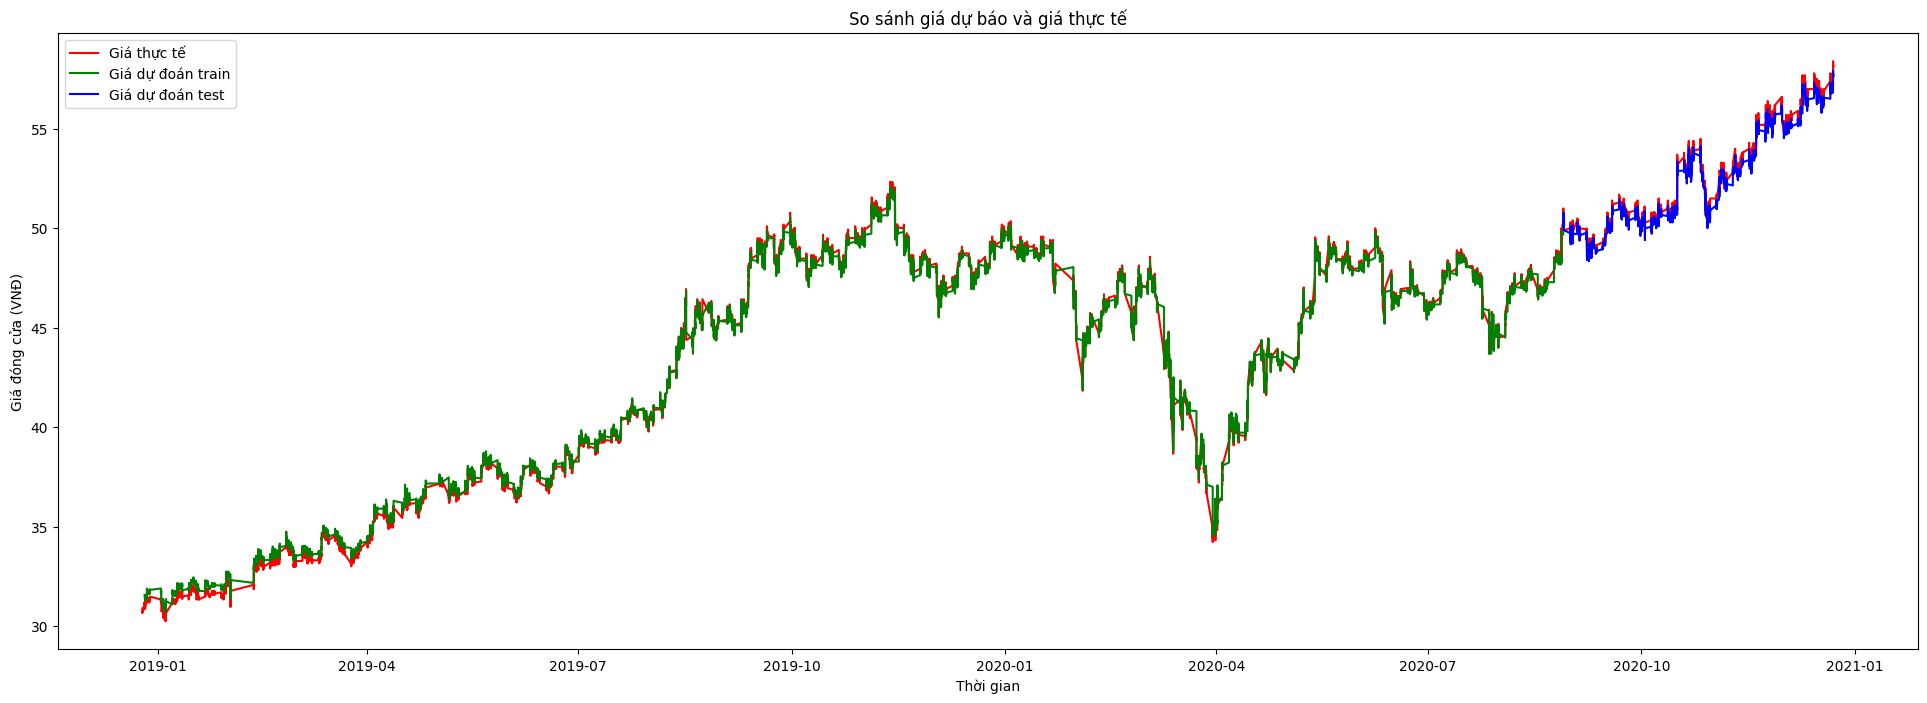

In [ ]:
#lập biểu đồ so sánh
train_data1 = df1[50:80000]
test_data1 = df1[80000:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [ ]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9989228499521894
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.15508054306574204
Phần trăm sai số tuyệt đối trung bình tập train: 0.00384464982578396


In [ ]:

train_data1

,Close,Dự đoán
Date/Time,,
2018-12-26 10:19:00,31.15,31.573933
2018-12-26 10:20:00,31.11,31.573587
2018-12-26 10:21:00,31.15,31.536655
2018-12-26 10:22:00,31.11,31.573570
2018-12-26 10:23:00,31.15,31.534355
...,...,...
2020-08-28 09:25:00,50.90,50.639652
2020-08-28 09:26:00,50.90,50.680309
2020-08-28 09:27:00,50.90,50.684639


In [ ]:

#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9860926929990947
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.283582051814212
Phần trăm sai số tuyệt đối trung bình tập test: 0.005303262513347687


In [ ]:
test_data1

,Close,Dự đoán
Date/Time,,
2020-08-28 09:30:00,50.9,50.702911
2020-08-28 09:31:00,51.0,50.684921
2020-08-28 09:32:00,51.0,50.757561
2020-08-28 09:33:00,50.9,50.775650
2020-08-28 09:34:00,50.9,50.703320
...,...,...
2020-12-22 14:24:00,58.2,57.700344
2020-12-22 14:25:00,58.2,57.725101
2020-12-22 14:26:00,58.2,57.735271


Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


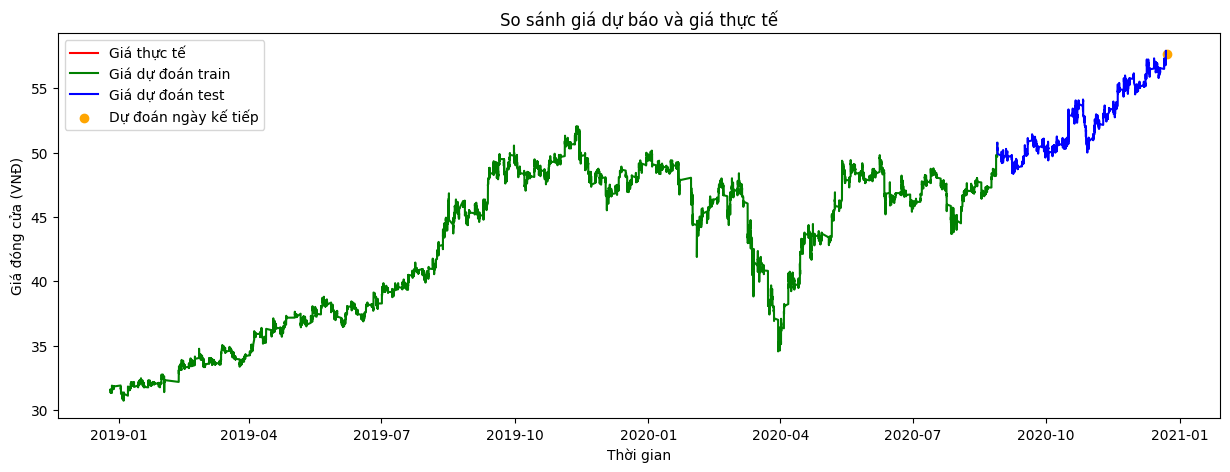

In [ ]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date/Time': [next_date], 'Close': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Date/Time'], df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()

In [ ]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Close'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Date/Time': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price],'Biến động giá': [y_next_predict[0][0] - actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

            Date/Time  Giá dự đoán  Giá ngày trước  Biến động giá
0 2020-12-23 14:46:00    57.654404            58.1      -0.445596
